In [1]:
from transformers import AutoConfig
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from vicuna_llava import llava, dataset_pretrain, dataset_instruct
from accelerate import Accelerator
accelerator = Accelerator()

Log in to huggingface (using llama requires you to request access on huggingface)

In [2]:
from huggingface_hub import login
login()

### Instantiate llava

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# grab vicuna and its tokenizer
model_name = "meta-llama/Llama-3.2-1B"#"lmsys/vicuna-7b-v1.5"
config = AutoConfig.from_pretrained(model_name)

llamallava = accelerator.prepare(llava(config, llmURL=model_name, accelerator=accelerator))


Grab pretrained projector

In [4]:
linear_llava_proj = torch.load('Pretrained/vicunallava_im_embedding_stage1.pt')

with torch.no_grad():
    llamallava.im_embedding.weight.copy_(linear_llava_proj.weight)
    llamallava.im_embedding.bias.copy_(linear_llava_proj.bias)

C:\Users\colli\AppData\Local\Temp\ipykernel_21416\2378572142.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  linear_llava_proj = torch.load('Pretrained/vicunallava_im_em

### Instantiate Dataset

In [9]:
# directories pointing to images directory and chat.json, I've downloaded the dataset locally to deal with some of the missing images
chat = 'CC3M/chat.json'
im_dir = "CC3M/images/"

num_samples=590000
subset_idcs = list(range(num_samples))

cc3m_dataset = accelerator.prepare(Subset(dataset_pretrain(chat, im_dir), subset_idcs))
batch_size=1
#cc3m_dataloader =  accelerator.prepare(DataLoader(cc3m_dataset, batch_size=batch_size))

im_dir_instruct = 'train2017/train2017/'
chat_instruct = 'LLaVA_Instruct_150k/llava_instruct_150k.json'
instruct_dataset = accelerator.prepare(dataset_instruct(chat_instruct,im_dir_instruct,llamallava.vision_tower))
#instruct_dataloader = accelerator.prepare(DataLoader(instruct_dataset, batch_size=batch_size))

Test Generating on Some Sample from Dataset

input prompt: Present a compact description of the photo's key features.
llava:  ###the bathroom is a small but well designed space with a shower and a toilet<|end_of_text|>
ground truth: there is even a sauna on board the house , which is said to be country most expensive after being valued at £ 3.7 million


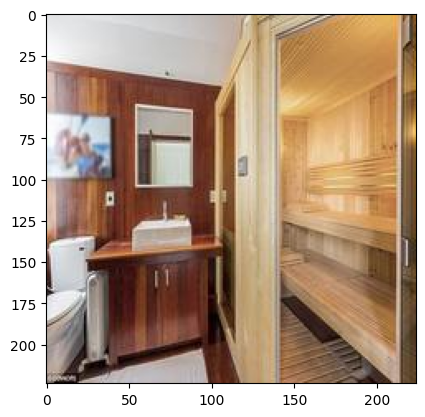

In [20]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, ToTensor
ToPIL = ToPILImage(mode='RGB')
rand_sample_idx = np.random.randint(low=0,high=len(cc3m_dataset))

# grab random sample from dataset
testprompt, testimage, testresponse = cc3m_dataset[rand_sample_idx]
testimage = testimage.to(device)

output = llamallava.generate(testimage, testprompt, max_new_tokens=20)
imagetoken = '<image>'
newlinetoken = '\n'
print(f'input prompt: {testprompt.replace(imagetoken,"").replace(newlinetoken,"")}')
print(f'llava: {output}')
print(f'ground truth: {testresponse}')
plt.imshow(ToPIL(testimage))

Test generating on any local image and prompt

input prompt: What might the temperature be in this image?
llava:  school building is a great example of a modern school building.###the school is a great example of


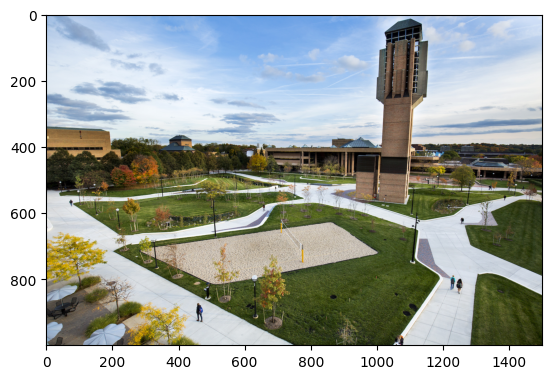

In [25]:
from PIL import Image
testprompt = 'What might the temperature be in this image?'
testimage = Image.open('UofM_NorthCampus.jpg')

output = llamallava.generate(testimage, testprompt, max_new_tokens=20)
print(f'input prompt: {testprompt}')
print(f'llava: {output}')
plt.imshow(testimage)

### Training

Set which parameters to be optimized

In [7]:
from torch.optim import Adam
from transformers import get_scheduler
from tqdm.auto import tqdm



optimizer =  accelerator.prepare(Adam([{"params":llamallava.parameters(),
                                        "params":llamallava.im_embedding.parameters()}], lr=2e-3))


num_epochs = 30
gradient_accumulation_steps = 1
num_dataset_samples = len(instruct_dataloader)
num_batch_steps = num_epochs*num_dataset_samples/batch_size
num_optim_steps = num_batch_steps/gradient_accumulation_steps
num_warmup_steps = np.ceil(0.03*num_optim_steps)
lr_scheduler = accelerator.prepare(get_scheduler("cosine",
                             optimizer=optimizer,
                             num_warmup_steps=num_warmup_steps,
                             num_training_steps=num_batch_steps))


#llamallava.staged_training(instruct_dataloader,
#                            stage=2, num_epochs=num_epochs,
#                            batch_size=batch_size, grad_accu_steps=gradient_accumulation_steps,
#                            optimizer=optimizer,lr_scheduler=lr_scheduler,
#                            save_results=False,push_to_hub=False,hf_user="cjschul")



NameError: name 'instruct_dataloader' is not defined

In [ ]:
instruct_dataset_full = accelerator.prepare(dataset_instruct(chat_instruct,im_dir_instruct,llamallava.vision_tower))
prompt, image, response = instruct_dataset_full.grab(0)

In [ ]:
prompt, _, _ = instruct_dataset[0]
prompt

'<image>\nWhat are the colors of the bus in the image?###The bus in the image is white and red.###What feature can be seen on the back of the bus?###The back of the bus features an advertisement.###Is the bus driving down the street or pulled off to the side?'

In [ ]:
prompt = 'Is the bus driving down the street or pulled off to the side?'
image = image.to(device)
output = llamallava.generate(image, prompt, max_new_tokens=15)
print(f'input prompt: {prompt}')

print(f'response: {output}')
print(f'ground truth: {response}')

c:\Users\colli\OneDrive\Documents\Classes\UofM\ECE 598 (LLMs)\Final Project\llava_finalproject\llava_finalproject\vicuna_llava.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


input prompt: Is the bus driving down the street or pulled off to the side?
response: ###The bus is the bus driving down the street or pulled off to the
ground truth: The bus in the image is white and red.
